This notebook calculates coherence for each pixel for each time/interferogram and saves the files. Then, I invert a coherence-weighted velocity/disp rate for each pixel over a few different time periods.  

This notebook: <br>
1. loads in unfilt, unwrapped igrams
2. references each igram to (A) the average of the whole igram, and (B) the average phase value within a small reference region
3. Inverts for average velocity with coherence as weights, covariance matrix guided by synthetic tests I did by converting Rowena's MATLAB code.

This notebook was written on 12-12-22. Edited 2-1-23.

***

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
%matplotlib  widget

# Need this function to convert datetime objects to decimal years. Got this off of stackexchange. 
def datetime2year(dt): 
    year_part = dt - datetime(year=dt.year, month=1, day=1)
    year_length = (
        datetime(year=dt.year + 1, month=1, day=1)
        - datetime(year=dt.year, month=1, day=1)
    )
    return dt.year + year_part / year_length

Do we want to run this notebook with filtered/unfiltered data? <br>
What about referenced to average phase value, reference box, or reference pixels chosen by "chooseing_reference_pixels.ipynb"

In [2]:
# choose one: 'filt' or 'unfilt'
key1 = 'unfilt'
# choose one: 'avg_val' or 'ref_box' or 'ref_pix'
key2 = 'ref_pix'

Grab dates of SLCs/igrams and calculate number of SLCs (nd) and igrams (numIgrams).

In [3]:
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
# shape of unwrapped igrams
# dx = 3000
# dy = 750

# larger cropped area with western mountains 
dx = 4000
dy = 1100

# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1

Load in the mask for reference pixels chosen with a few criteria. 

In [4]:
# load reference pixels mask 
#maskFile = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/masks/ref_pixels_mask.r4'
maskFile = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/masks/ref_pixels_mask.r4'
ds = gdal.Open(maskFile,gdal.GA_ReadOnly)
ref_mask = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
mask_y,mask_x = np.nonzero(ref_mask)
print('Reference pixel mask loaded.')

# filter size for calculating average reference pixels phase value for each igram.
alooks=4*4
rlooks=20*4
# filter it to use for reference pixel phase calculation.
ref_mask_filt = gaussian_filter(ref_mask,sigma = [alooks/2,rlooks/2])

Reference pixel mask loaded.


Load each igram, calculate the elevation vs. phase relationship (slope and intercept) for points with elevation over a threshold (capturing mostly just bedrock), save those values for each igram.

In [5]:
slopes = np.ndarray((numIgrams,),dtype='float')
intercepts = np.ndarray((numIgrams,),dtype='float')

elev_cutoff = 150

#igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/'+key1+'_unwrapped/'
igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'+key1+'_unwrapped/'

# load the DEM
driver=gdal.GetDriverByName('ISCE')
demDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/geom_reference'
x1 = 18000; x2 = 14000
y1 = 2100;  y2 = 1000

file = demDir+'/hgt.rdr.full'
ds = gdal.Open(file,gdal.GA_ReadOnly)
elev = ds.GetRasterBand(1).ReadAsArray(x2,y2,dx,dy)
print('DEM loaded.')

for i in range(numIgrams):
    igramFile = igramsDir+dates[i]+'_'+dates[i+1]+'_'+key1+'.unw'
    ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
    temp_igram = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
    # add condition that elevations over 125 m (relationship applies best for bedrock/high elevations)
    phs = temp_igram.flatten()[(elev.flatten() > elev_cutoff)]
    els = elev.flatten()[(elev.flatten() > elev_cutoff)]
    m, b = np.polyfit(els,phs,1)
    slopes[i] = m
    intercepts[i] = b
    print('i: '+str(i)+'\tslope: '+str(m)+' rad/m, \tintercept: '+str(b)+' rad.')
print('done.')

DEM loaded.
i: 0	slope: 0.01241251172152888 rad/m, 	intercept: 0.5799043700293077 rad.
i: 1	slope: -0.001237643759311598 rad/m, 	intercept: 5.66822597921317 rad.
i: 2	slope: 0.0037987951394297535 rad/m, 	intercept: 4.2320930782462955 rad.
i: 3	slope: -6.393251166938018e-05 rad/m, 	intercept: 4.812916999222578 rad.
i: 4	slope: -0.027911991791034194 rad/m, 	intercept: 5.389925756862012 rad.
i: 5	slope: 0.005120650929677574 rad/m, 	intercept: -7.321966912220836 rad.
i: 6	slope: 0.004388923178270809 rad/m, 	intercept: 8.735166537019571 rad.
i: 7	slope: 0.02175054278290128 rad/m, 	intercept: -0.1763825835690034 rad.
i: 8	slope: -0.010299991506888309 rad/m, 	intercept: 4.518148218134091 rad.
i: 9	slope: -0.015881993257742068 rad/m, 	intercept: 1.1693563857777867 rad.
i: 10	slope: 0.019133614867265468 rad/m, 	intercept: 2.512691782324248 rad.
i: 11	slope: -0.001999100959418041 rad/m, 	intercept: 6.937166182054907 rad.
i: 12	slope: 0.005216626524430997 rad/m, 	intercept: 6.064106445492683 rad.

Plot mask file to be sure I'm using the right ref pix.

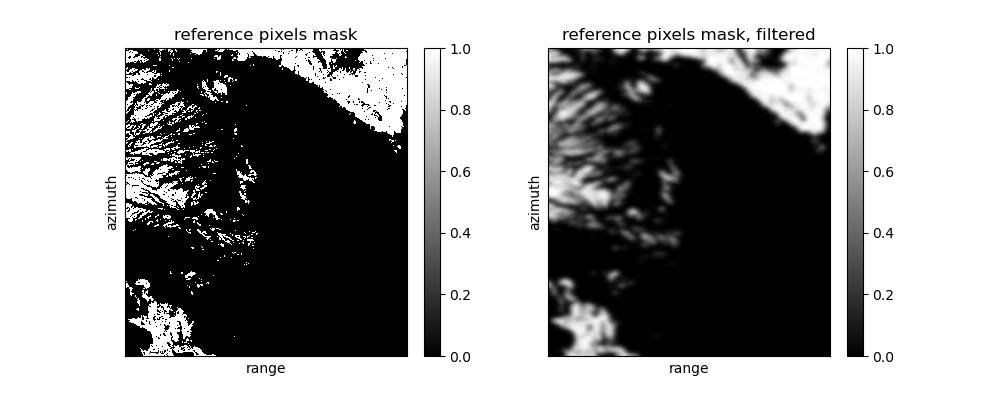

In [6]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(ref_mask, cmap='gray',aspect='auto',interpolation='nearest',vmin=0,vmax=1.0); plt.xlim(dx,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('reference pixels mask') 
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(ref_mask_filt, cmap='gray',aspect='auto',interpolation='nearest',vmin=0,vmax=1.0); plt.xlim(dx,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('reference pixels mask, filtered') 
plt.colorbar(); plt.show()

This stuff will change when I've calculated a ramp that I can remove. 

Read in each unfilt, unwrapped igram and calculate the average phase value over all reference pixels and save it into array. 

In [7]:
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
avg_ref_vals = np.ndarray((numIgrams,),dtype='float')
# ignore the divide-by-zero error messages that pop up in each loop iteration.
np.seterr(divide='ignore', invalid='ignore')

elev_min = min(elev.flatten())

# igramsDir is where the cropped, unwrapped igrams are
#igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/'+key1+'_unwrapped/'
igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'+key1+'_unwrapped/'
for i in range(numIgrams): # numIgrams if doing all of them at once
    igramFile = igramsDir+dates[i]+'_'+dates[i+1]+'_'+key1+'.unw'
    ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
    temp_igram = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
    
    # remove the topography effects
    temp_igram = temp_igram - (elev-elev_min)*slopes[i] # + intercepts[i]
    
    # Now mask the igram based on ref pixels and filter it.
    igram_masked = np.zeros((dy,dx))
    igram_masked[mask_y,mask_x] = temp_igram[mask_y,mask_x]
    igram_filt = gaussian_filter(igram_masked,sigma = [alooks/2,rlooks/2])
    ab = igram_filt / ref_mask_filt
    avg_ref_vals[i] = np.nanmean(ab) 
    print('i: '+str(i)+'\tavg_ref_val: '+str('%.4f' % avg_ref_vals[i]))
print('Avg value of ref pixels calculated for all '+key1+' igrams.')

# save space/RAM and clean up these variables now. 
del igramFile, ds, temp_igram

i: 0	avg_ref_val: 0.8398
i: 1	avg_ref_val: 5.7130
i: 2	avg_ref_val: 3.7992
i: 3	avg_ref_val: 3.7529
i: 4	avg_ref_val: 6.4950
i: 5	avg_ref_val: -6.3085
i: 6	avg_ref_val: 9.9731
i: 7	avg_ref_val: -1.7975
i: 8	avg_ref_val: 5.3528
i: 9	avg_ref_val: 1.3449
i: 10	avg_ref_val: 1.7233
i: 11	avg_ref_val: 6.3033
i: 12	avg_ref_val: 5.9253
i: 13	avg_ref_val: 2.6652
i: 14	avg_ref_val: 5.7721
i: 15	avg_ref_val: 3.4966
i: 16	avg_ref_val: 6.1781
i: 17	avg_ref_val: 5.7451
i: 18	avg_ref_val: 0.8076
i: 19	avg_ref_val: 1.8332
i: 20	avg_ref_val: 1.5750
i: 21	avg_ref_val: 0.3616
i: 22	avg_ref_val: 7.2572
i: 23	avg_ref_val: 4.9753
i: 24	avg_ref_val: 0.6021
i: 25	avg_ref_val: 0.9514
i: 26	avg_ref_val: 6.6875
i: 27	avg_ref_val: 4.6644
i: 28	avg_ref_val: 4.5025
i: 29	avg_ref_val: 1.9652
i: 30	avg_ref_val: -0.2609
i: 31	avg_ref_val: 2.0633
i: 32	avg_ref_val: 4.7120
i: 33	avg_ref_val: 1.6432
i: 34	avg_ref_val: 4.1200
i: 35	avg_ref_val: 6.0280
i: 36	avg_ref_val: 10.6655
i: 37	avg_ref_val: -2.7586
i: 38	avg_ref_val

^These filtered avg phase values for ref regions checks out with other code that calculates them one-by-one (in notebook: calculate_ramps_for_ref.ipynb)

Pull out dates in order to calculate disp rates over time.

In [8]:
# dates is a list of strings, convert strings to datetime objects 
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
# convert to floats 
slc_dates_floats = np.ndarray((len(slc_dates),1),dtype='float')
for i in range(len(slc_dates)):
    slc_dates_floats[i] = datetime2year(slc_dates[i]) # now an array of floats in years
# take numIgrams and pull out the igram_dates, corresponding to the second/last day of each igram
igram_dates = slc_dates[1::] # using the second SLC date per Rowena's suggestion
dt1 = np.diff(slc_dates) # calculate dt between slcs, these are now timedelta objects
# convert to floats 
dt_all = np.zeros([len(dt1),1])
for i in range(len(dt_all)):
    dt_all[i] = dt1[i].days #/365.25 # dt is now an array of floats (years btw slc acquisitions)
print('slc_dates: '+str(np.shape(slc_dates)[0]))
print('igram_dates: '+str(np.shape(igram_dates)[0]))

slc_dates: 211
igram_dates: 210


Avg ref value: 3.1976629942690673e+00


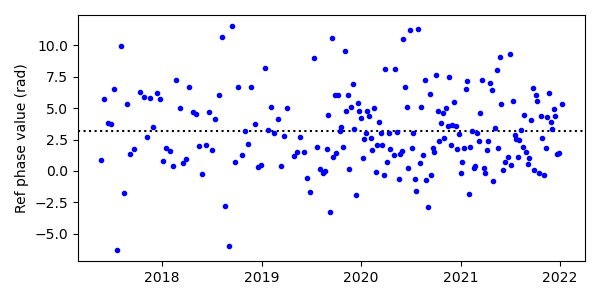

In [9]:
print('Avg ref value: '+str(np.mean(avg_ref_vals)))
plt.figure(figsize=(6,3),tight_layout=True)
plt.axhline(np.mean(avg_ref_vals),linestyle=':',color='k')
plt.plot(slc_dates[1::],avg_ref_vals,'b.')
plt.ylabel('Ref phase value (rad)')
plt.show()

Find which dates I need to separate the time series into to fit slopes for each pixel.

In [10]:
start_indices = [0,47,108,147,0,0,107]
end_indices = [46,107,146,numIgrams,88,numIgrams,153]
num_intervals = len(start_indices)

for i in range(num_intervals):
    print('interval '+str(i)+': '+str(dates[start_indices[i]]+' - '+str(dates[end_indices[i]])))
print('\ntotal duration of this study: '+str((igram_dates[-1]-igram_dates[0]).days/365.25)+' years')

interval 0: 20170510 - 20181125
interval 1: 20181207 - 20200412
interval 2: 20200418 - 20201208
interval 3: 20201214 - 20220108
interval 4: 20170510 - 20191220
interval 5: 20170510 - 20220108
interval 6: 20200412 - 20210119

total duration of this study: 4.632443531827516 years


Do one pixel for one interval and plot the time series to check if the weighted inversion is working.

210 dates in interval 5.


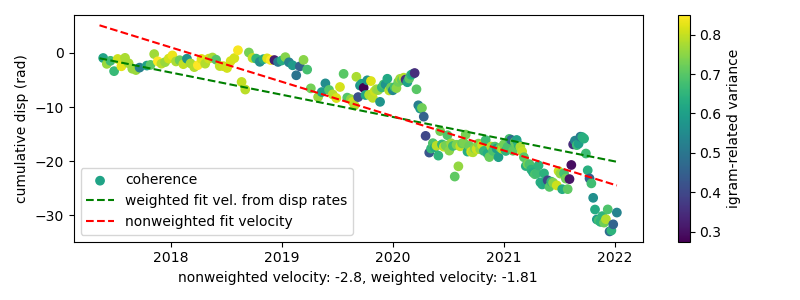

nonweighted velocity: 		-6.344541333040556 rad/yr 	-2.800369627170009 cm/yr
weighted vel from disp rates: 	-4.100785239468063 rad/yr 	-1.8100149135051824 cm/yr
RMSE to weighted fit: 		1.7902686517667434 rad/yr 	0.7901932848595004 cm/yr


In [15]:
driver=gdal.GetDriverByName('ISCE')
# if testing with a large disp value with bad coherence, set this key to 'test'
key = 'notest'
# which interval?
j = 5

# these are for figure showing two pixels, close together, with very different rates. 
# y2 = 443
# x2 = 3826
y2 = 445
x2 = 3824

y1 = 448
x1 = 3835


# choose an y,x coordinate, which pixel? 
y = y2
x = x2

#igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/'+key1+'_unwrapped/'
igramsDir =  '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'+key1+'_unwrapped/'
# cohDir =   '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_tip_LS_all_igrams/'
cohDir =     '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_LS_with_western_mtns_all_igrams/'
#saveDir =   '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_for_intervals/'
saveDir =    '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_with_western_mtns/'

# pick out indices from the interval (interval j)
interval_length = end_indices[j]-start_indices[j]
print(str(interval_length)+' dates in interval '+str(j)+'.')
# set up temp arrays for the row I'm extracting each time 
temp_phs = np.ndarray((interval_length,),dtype='float')
temp_coh = np.ndarray((interval_length,),dtype='float')
# load in phase values for single pixel, correct them (subtract avg ref value), load coherences for that row of pix
for i in range(interval_length):
    #print(start_indices[j]+i)
    date1 = dates[start_indices[j]+i]
    date2 = dates[start_indices[j]+i+1]
    igramFile = igramsDir+date1+'_'+date2+'_'+key1+'.unw'
    ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
    # only reading in one row at a time 
    temp_phs[i] = ds.GetRasterBand(1).ReadAsArray(x,y,1,1)     # (startx,starty,dx,dy)  
    # correct for topography 
    temp_phs[i] = temp_phs[i] - (elev[y,x]-elev_min)*slopes[i] # + intercepts[i])
    # correct based on avg ref values and topography correction
    temp_phs[i] = temp_phs[i] - avg_ref_vals[start_indices[j]+i]
    # load one line of coherence files
    cohFile = 'coh_'+date1+'-'+date2+'.r4'
    ds = gdal.Open(cohDir+cohFile, gdal.GA_ReadOnly)
    # only reading in one row at a time
    temp_coh[i] = ds.GetRasterBand(1).ReadAsArray(x,y,1,1)
# times of SLCs in interval j
t = slc_dates_floats[start_indices[j]:end_indices[j]+1]     # first index is starting SLC, end index+1 is end SLC
t_datetime = slc_dates[start_indices[j]:end_indices[j]+1]   # so igram dates are t[1::], this line is for better plotting
# this is date-related/atmospheric noise (instead of coherence/std.dev.s/variances which are speckle/igram-related)
noise_diags = np.ones(interval_length)*1.0                  # ones on diagonal 
noise_off_diags = np.ones(interval_length-1)*(-0.5)         # -0.5 on off diagonals
# date/atm-related noise covariance matrix
covi = np.diag(noise_diags,0)+np.diag(noise_off_diags,-1) \
    +np.diag(noise_off_diags,1) 
# coherence at that pixel over the interval, use this to calc variance.
coh_at_pixel = temp_coh                                     # all dates, just the one pixel 
variances = (-2*np.log(coh_at_pixel))                       # got this formula from Rowena's cor_sigma_test.m file 
if key=='test':
    # OPTIONAL: make the Nth variance a HUGE number to test 
    variances[20] = 100.0
vars_diag = np.diag(variances,0)
# Combine date-related and igram-related noise into proper covariance matrix 
covi2 = covi + vars_diag                                    # account for noise in individual igrams, ~speckle (not associated w/ a date, 2 igrams)
icov = np.linalg.inv(covi2)                                 # inverse of covariance matrix
# Make d(data) matrix (change in displacement over each igram, referenced to avg value over entire igram)
disps = np.copy(temp_phs)                                            # this is disp over igrams in interval, for the single pixel  
if key=='test':
    # OPTIONAL: make the Nth disp a HUGE number to test 
    disps[20] = -10.0
# Calculate cumulative displacement to do simple polyfit for comparison with weighted fit.
cum_disps = np.hstack((0,np.cumsum(disps)))
# make G matrix with 1's and -1's 
G_diags = np.ones((interval_length-1))
Gint = np.diag(G_diags,1)-1*np.eye(interval_length)         # -1's along diagonal, 1's on upper off diagonal
# plot covariance matrices 
# plt.figure(figsize=(9,3),tight_layout='TRUE')    
# plt.subplot(1,3,1); plt.imshow(covi,interpolation='nearest',vmin=-0.5,vmax=1.6)
# plt.colorbar(); plt.title('covi \n(igram-related noise)')
# plt.subplot(1,3,2); plt.imshow(covi2,interpolation='nearest',vmin=-0.5,vmax=1.6)
# plt.colorbar(); plt.title('covi2 \n(igram + date-related noise)')
# plt.subplot(1,3,3); plt.imshow(covi2-covi,interpolation='nearest')
# plt.colorbar(); plt.title('covi2 - covi'); plt.show() 
# calculate dt's (time intervals of each igram)
dt = np.diff(t.T)[0]                                        # the indices are weird from diff, the [0] index is actually the array we want.
# do inversion 
# USING DISP RATE (disp per igram) AND DT
G_disps = dt.reshape((interval_length,1))
Gg_disps_weighted = np.linalg.inv(G_disps.T.dot(icov).dot(G_disps)).dot(G_disps.T).dot(icov)
model_disp_rates = Gg_disps_weighted.dot(disps)             # weighted inversion directly from ints 
vel_disp_rate = model_disp_rates[0]                         # this just gives a velocity, no intercept 
# calculate a line from the weighted inversion for velocity, set intercept to zero.
line = vel_disp_rate*(t-t[0]) + 0.0
# make a conversion factor from radians to cm. 
wavelength = 5.5465763                                      # C-band, in cm 
rad2cm = wavelength/(4*np.pi)                               # this is conversion factor that I multiply by the data (which is in rads)
# a normal linear regression (to make sure weighted version is different)
m, b = np.polyfit(t.reshape((interval_length+1,)),cum_disps,1)
line_nonweighted = m*t+b

# plot cumulative displacements over the interval, colored by coherence. 
plt.figure(figsize=(8,3),tight_layout='TRUE')
#plt.plot(t_datetime,cum_disps,'k-'); plt.ylabel('rad')
plt.scatter(t_datetime[1::],cum_disps[1::],c=coh_at_pixel,label='coherence')
# need soemthing to align weighted disp rate with unweighted disp rate lines
offset = np.mean(line)-np.mean(line_nonweighted)
# plot the nonweighted vs. weighted fit lines 
plt.plot(t_datetime,line-offset,'g--',label='weighted fit vel. from disp rates')
plt.plot(t_datetime,line_nonweighted,'r--',label='nonweighted fit velocity')
plt.ylabel('cumulative disp (rad)'); plt.legend(); plt.colorbar(label='igram-related variance')
plt.xlabel('nonweighted velocity: '+str(np.round(rad2cm*m,3))+', weighted velocity: '+str(np.round(rad2cm*vel_disp_rate,3)))
plt.show()
print('nonweighted velocity: \t\t'+str(m)+' rad/yr \t'+str(rad2cm*m)+' cm/yr')
#print('weighted velocity: \t\t'+str(vel_cum_disp)+' rad/yr \t'+str(rad2cm*vel_cum_disp)+' cm/yr')
print('weighted vel from disp rates: \t'+str(vel_disp_rate)+' rad/yr \t'+str(rad2cm*vel_disp_rate)+' cm/yr')
rmse = np.std(disps-vel_disp_rate)
print('RMSE to weighted fit: \t\t'+str(rmse)+' rad/yr \t'+str(rad2cm*rmse)+' cm/yr')

Figure for paper: show weighted fits to population 1 pixel and population 2 pixel, differences btw unweighted and weighted inversions. 

In [12]:
print(vel_disp_rate)

-4.100785239468063


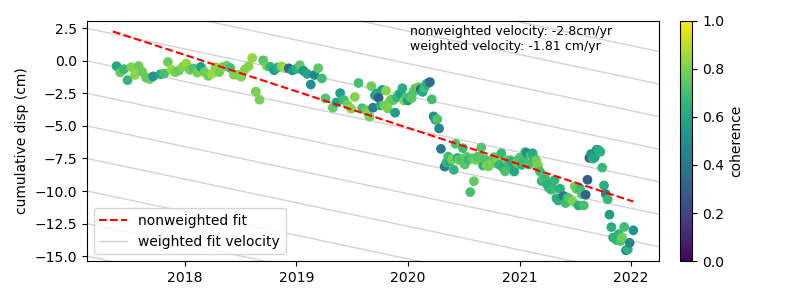

nonweighted velocity: 		-6.344541333040556 rad/yr 	-2.800369627170009 cm/yr
weighted vel from disp rates: 	-4.100785239468063 rad/yr 	-1.8100149135051824 cm/yr
RMSE to weighted fit: 		1.7902686517667434 rad/yr 	0.7901932848595004 cm/yr


In [13]:
# plot cumulative displacements over the interval, colored by coherence. 
plt.figure(figsize=(8,3),tight_layout='TRUE')
#plt.plot(t_datetime,cum_disps,'k-'); plt.ylabel('rad')
plt.scatter(t_datetime[1::],cum_disps[1::]*rad2cm,c=coh_at_pixel,vmin=0,vmax=1)
plt.plot(t_datetime,line_nonweighted*rad2cm,'r--',label='nonweighted fit')
plt.ylabel('cumulative disp (cm)'); 
plt.colorbar(label='coherence',pad=0.03)
#plt.xlabel('nonweighted velocity: '+str(np.round(rad2cm*m,3))+', weighted velocity: '+str(np.round(rad2cm*vel_disp_rate,3)))
plt.text(t_datetime[-120],0.8,'nonweighted velocity: '+str(np.round(rad2cm*m,3))+'cm/yr \nweighted velocity: '+str(np.round(rad2cm*vel_disp_rate,3))+' cm/yr',size=9)
Ymin,Ymax = plt.ylim()
Xmin,Xmax = plt.xlim()

for u in range(30):
    intercept = -20 + u*2.5
    x_vals = [Xmin,Xmax]
    y_vals = [(intercept),(intercept+vel_disp_rate*rad2cm*(Xmax-Xmin)/365.25)]
    plt.plot(x_vals, y_vals, '-', linewidth=1, c='lightgray',zorder=0)
plt.plot(x_vals, y_vals, '-', linewidth=1, c='lightgray',zorder=0, label='weighted fit velocity')

plt.ylim([Ymin,Ymax]); plt.xlim([Xmin,Xmax])
plt.legend(loc='lower left')
plt.show()

print('nonweighted velocity: \t\t'+str(m)+' rad/yr \t'+str(rad2cm*m)+' cm/yr')
#print('weighted velocity: \t\t'+str(vel_cum_disp)+' rad/yr \t'+str(rad2cm*vel_cum_disp)+' cm/yr')
print('weighted vel from disp rates: \t'+str(vel_disp_rate)+' rad/yr \t'+str(rad2cm*vel_disp_rate)+' cm/yr')
rmse = np.std(disps-vel_disp_rate)
print('RMSE to weighted fit: \t\t'+str(rmse)+' rad/yr \t'+str(rad2cm*rmse)+' cm/yr')

Do all inversions for an interval (or all intervals) here.

In [25]:
driver=gdal.GetDriverByName('ISCE')

# set up final arrays of weighted velocities and RMSE/residual stds
disp_rates_weighted = np.ndarray((num_intervals,dy,dx),dtype='float') 
disp_rates_residual_std = np.ndarray((num_intervals,dy,dx),dtype='float')

#igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/'+key1+'_unwrapped/'
igramsDir =  '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'+key1+'_unwrapped/'
# cohDir =   '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_tip_LS_all_igrams/'
cohDir =     '/data/ocp4/LagunaSalada/Data_and_Figs/2_coherence/coh_LS_with_western_mtns_all_igrams/'
#saveDir =   '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_for_intervals/'
saveDir =    '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_with_western_mtns/'
 
# loop through intervals 
for j in np.arange(5,6,1): #range(num_intervals), range(1) will just do the first interval 
    # pick out indices from the interval (interval j)
    interval_length = end_indices[j]-start_indices[j]
    print(str(interval_length)+' dates in interval '+str(j)+'.')
    print(key1)

    # set up temp arrays for the row I'm extracting each time 
    temp_phs = np.ndarray((interval_length,dx),dtype='float')       # axis 0 is date/igram index, axis 1 is x coordinate
    temp_coh = np.ndarray((interval_length,dx),dtype='float')

    # loop through rows
    for y in range(dy): # range(dy)
        # load in single row of phase values, correct them (subtract avg ref value), load coherences for that row of pix
        for i in range(interval_length):
            date1 = dates[start_indices[j]+i]
            date2 = dates[start_indices[j]+i+1]
            igramFile = igramsDir+date1+'_'+date2+'_'+key1+'.unw'
            ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
            # only reading in one row at a time 
            temp_phs[i] = ds.GetRasterBand(1).ReadAsArray(0,y,dx,1)     # (startx,starty,dx,dy)  
            
            #CHECK THIS
            # correct for topography 
            temp_phs[i] = temp_phs[i] - (elev[y,:] - elev_min) * slopes[i]
            
            
            # correct based on avg ref values
            temp_phs[i] = temp_phs[i] - avg_ref_vals[start_indices[j]+i]
            # load one line of coherence files
            cohFile = 'coh_'+date1+'-'+date2+'.r4'
            ds = gdal.Open(cohDir+cohFile, gdal.GA_ReadOnly)
            # only reading in one row at a time
            temp_coh[i] = ds.GetRasterBand(1).ReadAsArray(0,y,dx,1)
    
        # loop through pixels in that row and do weighted velocity inversion.
        for x in range(dx):   # dx for all pixels 
            t = slc_dates_floats[start_indices[j]:end_indices[j]+1]     # first index is starting SLC, end index+1 is end SLC
            t_datetime = slc_dates[start_indices[j]:end_indices[j]+1]   # so igram dates are t[1::], this line is for better plotting
            noise_diags = np.ones(interval_length)*1.0                  # ones on diagonal 
            noise_off_diags = np.ones(interval_length-1)*(-0.5)         # -0.5 on off diagonals
            covi = np.diag(noise_diags,0)+np.diag(noise_off_diags,-1) \
                +np.diag(noise_off_diags,1) 
            coh_at_pixel = temp_coh[:,x]                                # all dates, just the one pixel 
            variances = (-2*np.log(coh_at_pixel))                       # got this formula from Rowena's cor_sigma_test.m file 
            vars_diag = np.diag(variances,0)
            covi2 = covi + vars_diag                                    # account for noise in individual igrams, ~speckle (not associated w/ a date, 2 igrams)
            icov = np.linalg.inv(covi2)                                 # inverse of covariance matrix
            disps = temp_phs[:,x]                                       # this is disp over igrams in interval, for the single pixel  
            G_diags = np.ones((interval_length-1))
            Gint = np.diag(G_diags,1)-1*np.eye(interval_length)         # -1's along diagonal, 1's on upper off diagonal
            dt = np.diff(t.T)[0]                                        # the indices are weird from diff, the [0] index is actually the array we want.
            G_disps = dt.reshape((interval_length,1))
            Gg_disps_weighted = np.linalg.inv(G_disps.T.dot(icov).dot(G_disps)).dot(G_disps.T).dot(icov)
            model_disp_rates = Gg_disps_weighted.dot(disps)             # weighted inversion directly from ints 
            vel_disp_rate = model_disp_rates[0]                         # this just gives a velocity, no intercept 
            disp_rates_weighted[j,y,x] = vel_disp_rate                  # leave it in radians! 
            disp_rates_residual_std[j,y,x] = np.std(disps-vel_disp_rate)

        # print an update if we've gotten through 100*n rows
        if(np.remainder(y,100)==0):
            print('Row '+str(y)+' weighted inversions done.')

    # now save the disp rate and rmse files
    fileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'.r4'
    errorFileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'_residual_std.r4'
    colds = driver.Create(saveDir+fileName,dx,dy,1,gdal.GDT_Float32)
    colds.GetRasterBand(1).WriteArray(disp_rates_weighted[j])
    colds=None
    colds = driver.Create(saveDir+errorFileName,dx,dy,1,gdal.GDT_Float32)
    colds.GetRasterBand(1).WriteArray(disp_rates_residual_std[j])
    colds=None
    print('weighted disp rates and std of residuals saved for interval '+str(j))
print('done!') 

88 dates in interval 4.
filt
Row 0 weighted inversions done.
Row 100 weighted inversions done.
Row 200 weighted inversions done.
Row 300 weighted inversions done.
Row 400 weighted inversions done.
Row 500 weighted inversions done.
Row 600 weighted inversions done.
Row 700 weighted inversions done.
Row 800 weighted inversions done.
Row 900 weighted inversions done.
Row 1000 weighted inversions done.
weighted disp rates and std of residuals saved for interval 4
210 dates in interval 5.
filt
Row 0 weighted inversions done.
Row 100 weighted inversions done.
Row 200 weighted inversions done.
Row 300 weighted inversions done.
Row 400 weighted inversions done.
Row 500 weighted inversions done.
Row 600 weighted inversions done.
Row 700 weighted inversions done.
Row 800 weighted inversions done.
Row 900 weighted inversions done.
Row 1000 weighted inversions done.
weighted disp rates and std of residuals saved for interval 5
46 dates in interval 6.
filt
Row 0 weighted inversions done.
Row 100 we

^
Interval 0 took ~35 min. <br>
Interval 1 took 38 min. <br>
Interval 2 took 27 min. <br>
Interval 3 took ~30 maybe? min. <br>
Interval 4 took 40 min. <br>
Interval 5 took ~2.25 hr. <br>
Interval 6 took ?? min. <br>

Plot the weighted disp rate map.

In [ ]:
i = 3 # for 0-3 I used vmin=-5.0,vmax=5.0, but for 4-5 I used vmin=-3.0, vmax=3.0
#print('interval '+str(i)+', dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.figure(figsize=(6,5.5),tight_layout=True)
plt.imshow(disp_rates_weighted[i], aspect='auto', vmin=-3.0,vmax=3.0,\
            interpolation='nearest', extent = [0,dx,dy,0])
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.title('dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.show()

Load in disp rate map if haven't just run it. 

In [ ]:
driver=gdal.GetDriverByName('ISCE')

j = 1
fileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'.r4'
errorFileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'_residual_std.r4'

saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_with_western_mtns/'
disp_rates = np.ndarray((dy,dx),dtype='float') 
disp_rates_errors = np.ndarray((dy,dx),dtype='float') 

f1 = gdal.Open(saveDir+fileName, gdal.GA_ReadOnly)
disp_rates = f1.ReadAsArray()
f1 = None

f1 = gdal.Open(saveDir+errorFileName, gdal.GA_ReadOnly)
disp_rates_errors = f1.ReadAsArray()
f1 = None

print('interval '+str(j)+' disp rate map + errors loaded.')

In [ ]:
i = 1 # for 0-3 I used vmin=-5.0,vmax=5.0, but for 4-5 I used vmin=-3.0, vmax=3.0
#print('interval '+str(i)+', dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.figure(figsize=(6,5.5),tight_layout=True)
plt.imshow(disp_rates, aspect='auto', vmin=-2.0,vmax=2.0,\
            interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.title('dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.show()

plt.figure(figsize=(6,5.5),tight_layout=True)
plt.imshow(disp_rates_errors, aspect='auto',\
            interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.title('dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.show()